# RED NN

* Code mostly from https://github.com/red-nn/RED-NN
* Paper: https://hal-enpc.archives-ouvertes.fr/hal-02170933/document

In [1]:
from __future__ import print_function
import os
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models

In [2]:
# Load the 60,000 MNIST up-right oriented training samples and transform labels to one out of many format
data = np.load(f'MNIST_UR_train.npz')
x_train, y_train = data['x'], tf.keras.utils.to_categorical(data['y'], 10)

# Load the 10,000 MNIST randomly rotated training samples and transform labels to one out of many format
data = np.load('MNIST_RR_test.npz')
x_test, y_test = data['x'], tf.keras.utils.to_categorical(data['y'], 10)


# reshape to add alpha channel
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

# Normalize pixel values to be between 0 and 1
x_train, x_test = (x_train / 255.0).astype(np.float32), x_test.astype(np.float32) / 255.0

# Custom layers

In [3]:
class Rig2DConv(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, phi, un_rotate=True, padding='SAME', **kwargs):
        # Non-trainable variables initialization
        self.filters = filters
        self.un_rotate = un_rotate
        self.phi = phi
        self.pad = padding
        self.kernel_size = kernel_size
        self.ks = tf.constant(kernel_size, dtype='float32')
        self.angle = tf.constant(0, dtype='float32')
        self.angle2 = tf.constant(360, dtype='float32')
        self.ang = tf.linspace(self.angle, self.angle2, self.phi + 1)
        self.mid = tf.constant(0.5, dtype='float32')
        self.rds = tf.constant(np.pi / 180, dtype='float32')
        self.center = tf.round((self.ks * self.mid) - self.mid)
        super(Rig2DConv, self).__init__(**kwargs)

    def build(self, input_shape):
        # Trainable variables initialization
        self._l = self.add_weight(name='l', shape=(self.filters,), initializer=tf.compat.v1.initializers.constant(value=0.5111867),
                                  trainable=True, constraint=tf.keras.constraints.NonNeg())
        self.alpha = self.add_weight(name='alpha', shape=(self.filters,), initializer=tf.compat.v1.initializers.constant(value=0.5651333),
                                     trainable=True, constraint=tf.keras.constraints.NonNeg())
        self.beta = self.add_weight(name='beta', shape=(self.filters,), initializer=tf.compat.v1.initializers.constant(value=1.4184482),
                                    trainable=True,  constraint=tf.keras.constraints.NonNeg())
        # Input size dependent variables
        self.nf = input_shape[-1]
        self.width = input_shape[-2]
        self.height = input_shape[-3]

        super(Rig2DConv, self).build(input_shape)

    def call(self, x, **kwargs):
        # Generate a set of coordinates
        d = tf.range(self.ks)
        x_coord, y_coord = tf.meshgrid(d, d)
        x_coord = tf.cast(x_coord, dtype="float32") - self.center
        y_coord = tf.cast(y_coord, dtype="float32") - self.center

        # Horizontal basis filter
        arx = tf.math.divide((-2 * self.alpha[0] * tf.square(self._l[0]) * x_coord), np.pi) * tf.exp(
            -self._l[0] * ((self.alpha[0] * tf.square(x_coord)) + (self.beta[0] * tf.square(y_coord))))

        # Vertical basis filter
        ary = tf.math.divide((-2 * self.beta[0] * tf.square(self._l[0]) * y_coord), np.pi) * tf.exp(
            -self._l[0] * ((self.alpha[0] * tf.square(x_coord)) + (self.beta[0] * tf.square(y_coord))))

        arx = tf.expand_dims(arx, axis=-1)
        ary = tf.expand_dims(ary, axis=-1)

        # First filter generation
        ar = (tf.cos(self.ang[0] * self.rds) * arx) + (tf.sin(self.ang[0] * self.rds) * ary)
        # Convolve input with first generated filter
        par1 = tf.nn.conv2d(input=x, filters=tf.reshape(ar, (self.ks, self.ks, self.nf, 1)), strides=(1, 1, 1, 1), padding=self.pad)
        # Rotation compensation to get translational feature space
        par2 = tfa.image.rotate(par1, self.ang[0] * self.rds, interpolation='BILINEAR')

        # Second filter generation
        ar1 = (tf.cos(self.ang[1] * self.rds) * arx) + (tf.sin(self.ang[1] * self.rds) * ary)
        # Convolve input with second generated filter
        par3 = tf.nn.conv2d(input=x, filters=tf.reshape(ar1, (self.ks, self.ks, self.nf, 1)), strides=(1, 1, 1, 1), padding=self.pad)
        # Rotation compensation to get translational feature space
        par4 = tfa.image.rotate(par3, self.ang[1] * self.rds, interpolation='BILINEAR')

        if self.un_rotate:
            out = tf.concat([par2, par4], axis=3)
        else:
            out = tf.concat([par1, par3], axis=3)

        # Apply same process from filters up to Phi
        for aa in range(2, self.phi):
            ar = (tf.cos(self.ang[aa] * self.rds) * arx) + (tf.sin(self.ang[aa] * self.rds) * ary)
            partial = tf.nn.conv2d(input=x, filters=tf.reshape(ar, (self.ks, self.ks, self.nf, 1)), strides=(1, 1, 1, 1),
                                   padding=self.pad)
            partial2 = tfa.image.rotate(partial, self.ang[aa] * self.rds, interpolation='BILINEAR')
            if self.un_rotate:
                out = tf.concat([out, partial2], axis=3)
            else:
                out = tf.concat([out, partial], axis=3)
        out_f1 = tf.reshape(out, shape=(-1, self.height, self.width, self.phi, 1))
        out_f1 = tf.transpose(a=out_f1, perm=(0, 3, 1, 2, 4))

        # If only one filter ensemble is used return this
        if self.filters == 1:
            return out_f1
        # If more ensembles are required do the same
        arx = tf.math.divide((-2 * self.alpha[1] * tf.square(self._l[1]) * x_coord), np.pi) * tf.exp(
            -self._l[1] * ((self.alpha[1] * tf.square(x_coord)) + (self.beta[1] * tf.square(y_coord))))

        ary = tf.math.divide((-2 * self.beta[1] * tf.square(self._l[1]) * y_coord), np.pi) * tf.exp(
            -self._l[1] * ((self.alpha[1] * tf.square(x_coord)) + (self.beta[1] * tf.square(y_coord))))

        arx = tf.expand_dims(arx, axis=-1)
        ary = tf.expand_dims(ary, axis=-1)

        ar = (tf.cos(self.ang[0] * self.rds) * arx) + (tf.sin(self.ang[0] * self.rds) * ary)
        par1 = tf.nn.conv2d(input=x, filters=tf.reshape(ar, (self.ks, self.ks, self.nf, 1)), strides=(1, 1, 1, 1), padding=self.pad)
        par2 = tfa.image.rotate(par1, self.ang[0] * self.rds, interpolation='BILINEAR')

        ar1 = (tf.cos(self.ang[1] * self.rds) * arx) + (tf.sin(self.ang[1] * self.rds) * ary)
        par3 = tf.nn.conv2d(input=x, filters=tf.reshape(ar1, (self.ks, self.ks, self.nf, 1)), strides=(1, 1, 1, 1), padding=self.pad)
        par4 = tfa.image.rotate(par3, self.ang[1] * self.rds, interpolation='BILINEAR')

        if self.un_rotate:
            out = tf.concat([par2, par4], axis=3)
        else:
            out = tf.concat([par1, par3], axis=3)

        for aa in range(2, self.phi):
            ar = (tf.cos(self.ang[aa] * self.rds) * arx) + (tf.sin(self.ang[aa] * self.rds) * ary)
            partial = tf.nn.conv2d(input=x, filters=tf.reshape(ar, (self.ks, self.ks, self.nf, 1)), strides=(1, 1, 1, 1),
                                   padding=self.pad)
            partial2 = tfa.image.rotate(partial, self.ang[aa] * self.rds, interpolation='BILINEAR')
            if self.un_rotate:
                out = tf.concat([out, partial2], axis=3)
            else:
                out = tf.concat([out, partial], axis=3)
        out_f2 = tf.reshape(out, shape=(-1, self.height, self.width, self.phi, 1))
        out_f2 = tf.transpose(a=out_f2, perm=(0, 3, 1, 2, 4))

        out_final = tf.concat([out_f1, out_f2], axis=4)

        for bb in range(2, self.filters):

            arx = tf.math.divide((-2 * self.alpha[bb] * tf.square(self._l[bb]) * x_coord), np.pi) * tf.exp(
                -self._l[bb] * ((self.alpha[bb] * tf.square(x_coord)) + (self.beta[bb] * tf.square(y_coord))))

            ary = tf.math.divide((-2 * self.beta[bb] * tf.square(self._l[bb]) * y_coord), np.pi) * tf.exp(
                -self._l[bb] * ((self.alpha[bb] * tf.square(x_coord)) + (self.beta[bb] * tf.square(y_coord))))

            arx = tf.expand_dims(arx, axis=-1)
            ary = tf.expand_dims(ary, axis=-1)

            ar = (tf.cos(self.ang[0] * self.rds) * arx) + (tf.sin(self.ang[0] * self.rds) * ary)
            par1 = tf.nn.conv2d(input=x, filters=tf.reshape(ar, (self.ks, self.ks, self.nf, 1)), strides=(1, 1, 1, 1),
                                padding=self.pad)
            par2 = tfa.image.rotate(par1, self.ang[0] * self.rds, interpolation='BILINEAR')

            ar1 = (tf.cos(self.ang[1] * self.rds) * arx) + (tf.sin(self.ang[1] * self.rds) * ary)
            par3 = tf.nn.conv2d(input=x, filters=tf.reshape(ar1, (self.ks, self.ks, self.nf, 1)), strides=(1, 1, 1, 1),
                                padding=self.pad)
            par4 = tfa.image.rotate(par3, self.ang[1] * self.rds, interpolation='BILINEAR')

            if self.un_rotate:
                out = tf.concat([par2, par4], axis=3)
            else:
                out = tf.concat([par1, par3], axis=3)

            for aa in range(2, self.phi):
                ar = (tf.cos(self.ang[aa] * self.rds) * arx) + (tf.sin(self.ang[aa] * self.rds) * ary)
                partial = tf.nn.conv2d(input=x, filters=tf.reshape(ar, (self.ks, self.ks, self.nf, 1)), strides=(1, 1, 1, 1),
                                       padding=self.pad)
                partial2 = tfa.image.rotate(partial, self.ang[aa] * self.rds, interpolation='BILINEAR')
                if self.un_rotate:
                    out = tf.concat([out, partial2], axis=3)
                else:
                    out = tf.concat([out, partial], axis=3)
            out_fn = tf.reshape(out, shape=(-1, self.height, self.width, self.phi, 1))
            out_fn = tf.transpose(a=out_fn, perm=(0, 3, 1, 2, 4))

            out_final = tf.concat([out_final, out_fn], axis=4)

        return out_final

    def get_config(self):
        base_config = super(Rig2DConv, self).get_config()
        base_config['filters'] = self.filters
        base_config['kernel_size'] = self.kernel_size
        base_config['phi'] = self.phi
        return base_config

    @classmethod
    def from_config(cls, config):
        return cls(**config)




In [4]:
# A cyclic convolution can be implemented with a linear convolution over a periodically padded feature space
class Periodic_Pad(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Periodic_Pad, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Periodic_Pad, self).build(input_shape)

    def call(self, inputs):
        x = tf.concat([inputs, inputs], axis=1)
        return x[:, :-1, :, :, :]

    def get_config(self):
        base_config = super(Periodic_Pad, self).get_config()
        return base_config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# Setting up the model

In [5]:
# Input image size
ROWS = 28
COLS = 28

# Angular samples (PHI)
PHI = 16

# Number of filters for each convolution stage
CONV1_F = 16
CONV2_F = 16
CONV3_F = 16

# Model definition
in_shape = tf.keras.Input(shape=(ROWS, COLS, 1), name="Input")

## Layers

In [6]:
x = Rig2DConv(filters=1, kernel_size=10, phi=PHI, un_rotate=True, name="Rig")(in_shape)
# Periodic padding for cyclic convolution
x = Periodic_Pad()(x)

# 3 stacked convolutional predictors with batch normalization
x = tf.keras.layers.BatchNormalization(name="BN1")(x)
x = tf.keras.layers.Conv3D(CONV1_F, kernel_size=(1, 5, 5), activation='relu', name="CONV1")(x)
x = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), name="MP1")(x)

x = tf.keras.layers.BatchNormalization(name="BN2")(x)
x = tf.keras.layers.Conv3D(CONV2_F, kernel_size=(1, 3, 3), activation='relu', name="CONV2")(x)
x = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), name="MP2")(x)

# Translational convolution over the depth axis of the feature space
x = tf.keras.layers.BatchNormalization(name="BN3")(x)
x = tf.keras.layers.Conv3D(CONV3_F, kernel_size=(PHI, 3, 3), activation='relu', name="CONV3")(x)

# Dense hidden layer predictor
x = tf.keras.layers.Reshape((PHI, 3*3*CONV3_F))(x)
x = tf.keras.layers.Dense(30, activation='relu', name="Hidden_Dense")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10, activation='softmax', name="Output_table")(x)

# Maxpooling applied to the columns results in the predicted class
number = tf.keras.layers.GlobalMaxPooling1D(name="number")(x)
x_permuted = tf.keras.layers.Permute((2, 1))(x)
# Maxpooling applied to the rows results in the predicted angle row index
angle = tf.keras.layers.GlobalMaxPooling1D(name="angle")(x_permuted)
# ----------------------------------------------------------------------------------------------------------------------

model = tf.keras.Model(inputs=in_shape, outputs=number)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
Rig (Rig2DConv)              (None, 16, 28, 28, 1)     3         
_________________________________________________________________
periodic__pad (Periodic_Pad) (None, 31, 28, 28, 1)     0         
_________________________________________________________________
BN1 (BatchNormalization)     (None, 31, 28, 28, 1)     4         
_________________________________________________________________
CONV1 (Conv3D)               (None, 31, 24, 24, 16)    416       
_________________________________________________________________
MP1 (MaxPooling3D)           (None, 31, 12, 12, 16)    0         
_________________________________________________________________
BN2 (BatchNormalization)     (None, 31, 12, 12, 16)    64    

## Training the model

In [8]:
# Training section
opt = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

In [9]:
name = f'URT_REDNN_v2_{PHI}'

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
checkpoint = tf.keras.callbacks.ModelCheckpoint(name + '.h5', verbose=1, save_best_only=True, monitor='val_loss', mode='min')
tensorboardcb = tf.keras.callbacks.TensorBoard(log_dir=os.path.join('tests', name), write_images=True, write_grads=True)

In [10]:
model_path = 'models/RED_NN_v2_50'
#x_test_r = [tfa.image.rotate(x, np.random.uniform(-np.pi/2., np.pi/2.)).numpy() for x in x_test]

if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    history = None
else:
    history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=50,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[reduce_lr, checkpoint, tensorboardcb])
    
model.save(model_path)

Epoch 1/50
469/469 [==============================] - 1718s 4s/step - loss: 1.2144 - accuracy: 0.7803 - val_loss: 1.0081 - val_accuracy: 0.8257

Epoch 00001: val_loss improved from inf to 1.00813, saving model to URT_REDNN_v2_16.h5
Epoch 2/50
469/469 [==============================] - 1705s 4s/step - loss: 0.7045 - accuracy: 0.9630 - val_loss: 0.8335 - val_accuracy: 0.8919

Epoch 00002: val_loss improved from 1.00813 to 0.83353, saving model to URT_REDNN_v2_16.h5
Epoch 3/50
469/469 [==============================] - 1706s 4s/step - loss: 0.6743 - accuracy: 0.9722 - val_loss: 0.8034 - val_accuracy: 0.8997

Epoch 00003: val_loss improved from 0.83353 to 0.80335, saving model to URT_REDNN_v2_16.h5
Epoch 4/50
469/469 [==============================] - 1705s 4s/step - loss: 0.6638 - accuracy: 0.9754 - val_loss: 0.9030 - val_accuracy: 0.8684

Epoch 00004: val_loss did not improve from 0.80335
Epoch 5/50
469/469 [==============================] - 1705s 4s/step - loss: 0.6555 - accuracy: 0.978

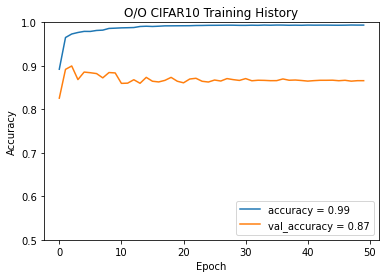

In [11]:
if history:
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    plt.plot(history.history['accuracy'], label=f'accuracy = {train_acc:.2f}')
    plt.plot(history.history['val_accuracy'], label = f'val_accuracy = {val_acc:.2f}')
    plt.title('O/O CIFAR10 Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

# Evaluate on rotated images

In [12]:
model.evaluate(x_test, y_test, verbose=2)

313/313 - 28s - loss: 0.8405 - accuracy: 0.8659


[0.8404873013496399, 0.8658999800682068]

# Their results

In [15]:
model2 = tf.keras.models.load_model('RRT_REDNN_16.h5', custom_objects={'Rig2DConv': Rig2DConv,
                                                                             'Periodic_Pad': Periodic_Pad})

model2.summary()

model2.evaluate(x_test, y_test)

Model: "model_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
Rig (Rig2DConv)              (None, 16, 28, 28, 1)     3         
_________________________________________________________________
periodic__pad_75 (Periodic_P (None, 31, 28, 28, 1)     0         
_________________________________________________________________
BN1 (BatchNormalization)     (None, 31, 28, 28, 1)     4         
_________________________________________________________________
CONV1 (Conv3D)               (None, 31, 24, 24, 16)    416       
_________________________________________________________________
MP1 (MaxPooling3D)           (None, 31, 12, 12, 16)    0         
_________________________________________________________________
BN2 (BatchNormalization)     (None, 31, 12, 12, 16)    64 

[0.5962042212486267, 0.9857000112533569]

In [17]:
model3 = tf.keras.models.load_model('URT_REDNN_16_orig.h5', custom_objects={'Rig2DConv': Rig2DConv,
                                                                             'Periodic_Pad': Periodic_Pad})

model3.summary()

model3.evaluate(x_test, y_test)

Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
Rig (Rig2DConv)              (None, 16, 28, 28, 1)     3         
_________________________________________________________________
periodic__pad_33 (Periodic_P (None, 31, 28, 28, 1)     0         
_________________________________________________________________
BN1 (BatchNormalization)     (None, 31, 28, 28, 1)     4         
_________________________________________________________________
CONV1 (Conv3D)               (None, 31, 24, 24, 16)    416       
_________________________________________________________________
MP1 (MaxPooling3D)           (None, 31, 12, 12, 16)    0         
_________________________________________________________________
BN2 (BatchNormalization)     (None, 31, 12, 12, 16)    64 

[0.7012384533882141, 0.9750999808311462]